Querying some models can be very expensive, taking up to a couple of hours for one input. Hence, algorithms like MCMC that require constantly query the model becp,e impractical. To solve this problem, it's usefull to use an emulator. Emulator is a new model, trained on the queries from the original model, that can be queried for unobserved inputs much faster. This notebooks shows how Gaussian Processes Emulator in pints can be used to model the log_likelihood of a Logistic Model.

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt
import GPy

import pints.emulator as emulator
import pints.emulator.utils as emutils
import pints.emulator.plot as emuplt

import copy

%matplotlib inline

# Creating the model 

In [2]:
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Create bounds for our parameters
boundaries = pints.Boundaries([0.01, 400], [0.02, 600])


# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

In [3]:
# Create a uniform prior over parameters
log_prior = pints.UniformLogPrior(
    boundaries
)

## Generating training data

In [4]:
input_parameters = log_prior.sample(400)
input_parameters[:5]

array([[1.00238021e-02, 4.67077211e+02],
       [1.90183114e-02, 4.00224364e+02],
       [1.62356884e-02, 4.67138749e+02],
       [1.34090353e-02, 4.80427366e+02],
       [1.34476241e-02, 4.63629817e+02]])

In [5]:
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

array([-92773.81621556, -33596.94962918,  -7234.62783247, -11993.96659456,
       -15142.72474665])

## Create and train a GP emulator

Emulator is initialized by providing the instance of likelihood PDF being emulated, input array of shape $N \times n\_parameters$ and a target array of shape $N \times 1$. 
When using Gaussian Processes we standardize inputs and outputs, this helps GP to get a better fit as it assumes that the mean of the GP is 0, so it helps if the input data meets this criteria. Standardizing inputs is also usefull, as it helps to select initial parameters for the covariance function.

In [6]:
emu = emulator.GPEmulator(log_likelihood, 
                          input_parameters, 
                          likelihoods,
                          normalize_input = True)
emu.set_parameters(kernel = GPy.kern.Linear(emu.n_parameters()) )
emu.fit(normalizer = True)
emu.summary()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0006   5.538050e+02   9.295782e-01 
    00s10  0012   5.518132e+02   7.653472e+00 
    00s14  0017   5.517263e+02   1.807199e-08 
Runtime:     00s14
Optimization status: Converged

Summary
Kernel:
   linear.    |               value  |  constraints  |  priors
  variances  |  0.0444441356663894  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  default

Name : GP regression
Objective : 551.7262986172957
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  linear.variances         |  0.0444441356663894  |      +ve      |        
  Gaussian_noise.variance  |  0.9099598805974274  |      +ve      |        


Now we can query prediction from the emulator just like we can from any log-pdf. Since the output of a GP is a normal distribution, we just automatically sample from it. To get the mean and variance at a particular point you can use emu.predict function

In [7]:
emu([0.015, 500])

array([[-28643.09603363]])

## Surface plots

To visuallize the performance of our emulator it's usefull to look at the surface plots <br>

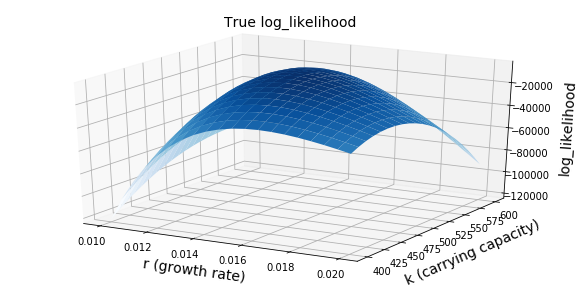

In [8]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = emutils.generate_grid(boundaries.lower(), 
                                                  boundaries.upper(), 
                                                  test_splits)

model_prediction = emutils.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
emuplt.surface(r_grid, k_grid, model_prediction, title = "True log_likelihood",
                     x_label = "r (growth rate)",
                     y_label = "k (carrying capacity)")

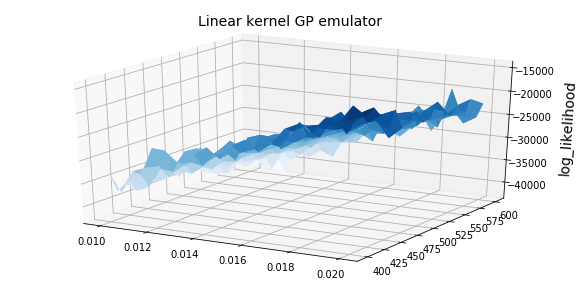

In [9]:
emu_prediction = emutils.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = emuplt.surface(r_grid, 
                    k_grid, 
                    emu_prediction, 
                    title = "Linear kernel GP emulator")

It's often helpful to plot the differences between corresponding inputs.

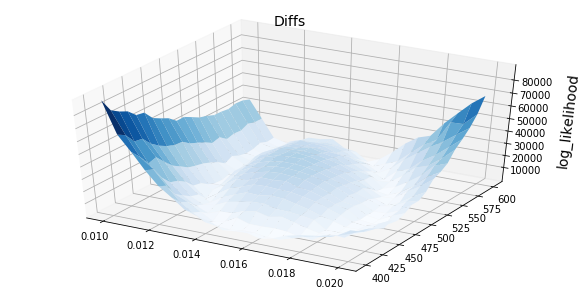

In [10]:
diffs = np.abs(model_prediction - emu_prediction)

plt.figure(figsize = (10, 5))
ax = emuplt.surface(r_grid, 
                    k_grid, 
                    diffs, 
                    title = "Diffs", 
                    angle = (40, 300))

## Comparison of different kernels

Now we try a number of different kernels to find out which ones work the best for Logistic ODE. Note, an important feature of kernels is that they can be added and multiplied together to produce new kernels. <br>
We use log_marginal_likelihood to as a objective functino for GP's performance

In [11]:
input_dim = 2
kernels_and_names = [
    (GPy.kern.White(input_dim), "White"),
    (GPy.kern.Linear(input_dim), "Linear"),
    (GPy.kern.Matern52(input_dim), "Matern52"),
    (GPy.kern.RBF(input_dim), "RBF"),
    (GPy.kern.MLP(input_dim), "MLP"),
    (GPy.kern.RatQuad(input_dim), "RatQuad"),
    # combinations
    (GPy.kern.Linear(input_dim) * GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim), "Linear * Linear + White"),
    (GPy.kern.RBF(input_dim) * GPy.kern.RBF(input_dim), "RBF * RBF"),
    (GPy.kern.Matern52(input_dim, variance = 1.) + GPy.kern.RBF(input_dim, variance = 1.), "Matern52 + RBF"),
    (GPy.kern.RBF(input_dim) + GPy.kern.RBF(input_dim, lengthscale = 0.01) * GPy.kern.RBF(input_dim), 
     "RBF + RBF[variance=0.01]*RBF"),
]

# differents optimizers:
# SCG
# possible optimizers: ‘scg’, ‘lbfgs’, ‘tnc’.
# 'scg' and 'tnc' require the data to be normalized
#  can put the max on the number of iterations using max_iter = 100
# 'lbfgs' seems to be the default and performs well for MLP and RatQuad
optimizer = 'lbfgs'
emu.set_parameters(optimizer=optimizer)

 /Users/maksympetyak/Prog/pints/pints/emulator/_gp_emulator.py:58: UserWarning:Non-negative log_likelihood predicted. Indicative of high uncertainty in predictions.
 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.


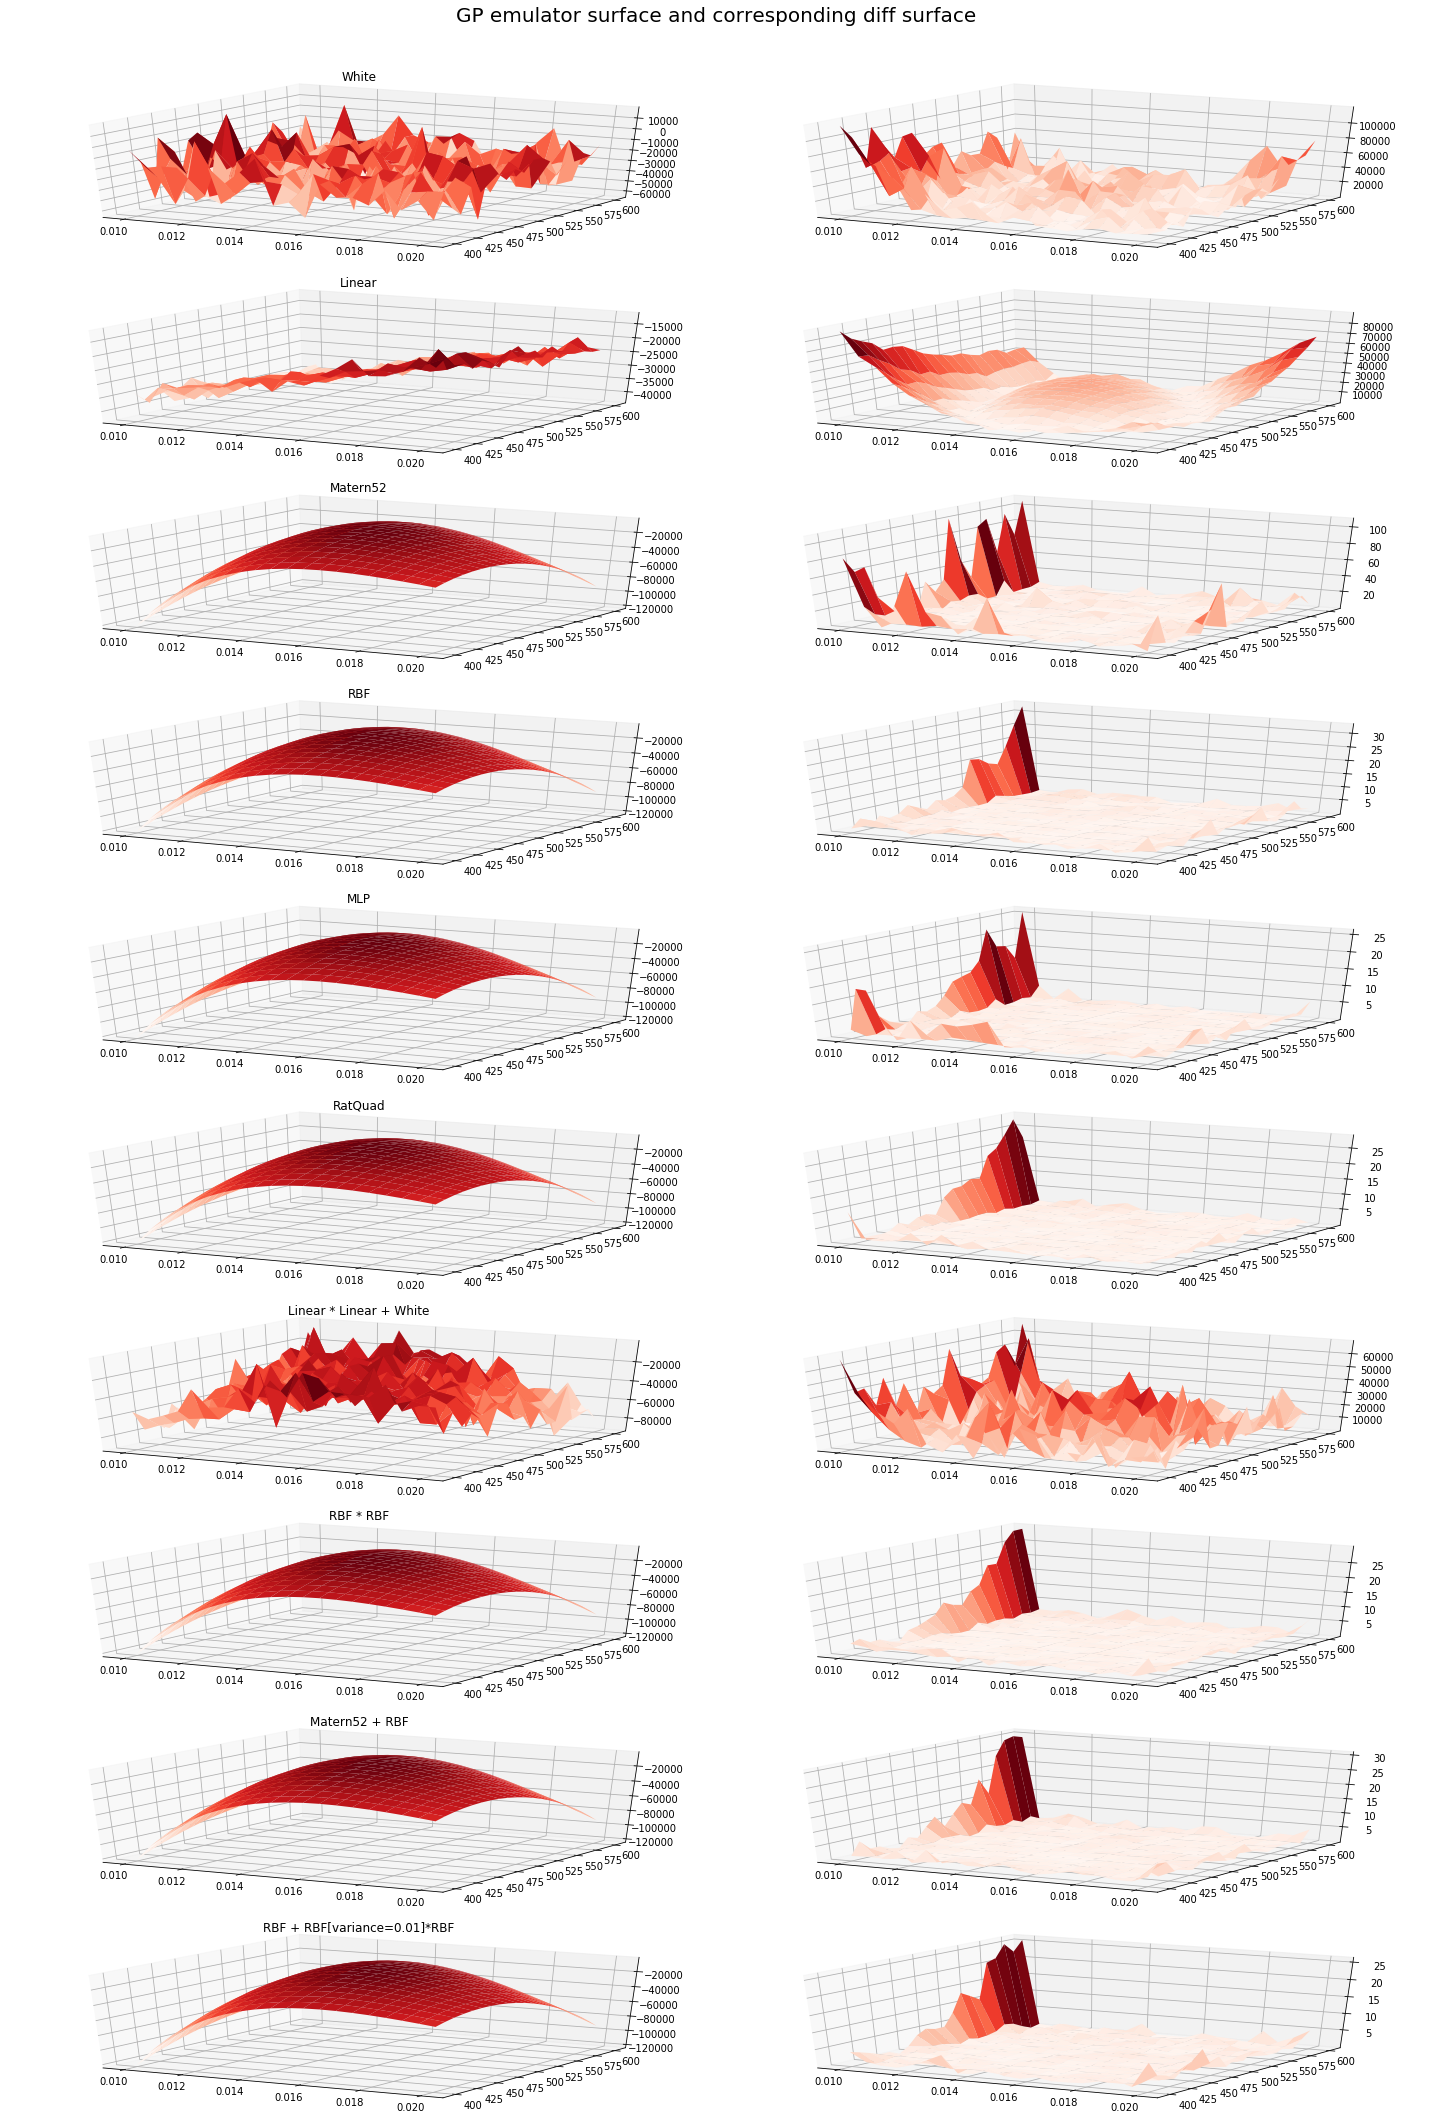

In [12]:
l = len(kernels_and_names)

marginal_log_likelihoods = []

fig = plt.figure(figsize = (20, 30))


for row in range(l):

    kernel, name = kernels_and_names[row]
    
    
    emu.set_parameters(kernel = kernel)
    emu.fit(messages = False, normalizer = True) # change of parameters requires the model to be refitted
    emu_prediction = emutils.predict_grid(emu, test_data)
    diffs = np.abs(model_prediction - emu_prediction)
    
    # store errors
    marginal_log_likelihoods.append(emu.get_log_marginal_likelihood())
    
    # plot surface of GP
    gp = emu.get_gp()
    ax1 = fig.add_subplot(l, 2, 2*row + 1, projection = '3d')
    #ax1.set_zlim(-800000, 0)
    ax1.set_title(name)
    ax1.plot_surface(r_grid, k_grid, emu_prediction, cmap = "Reds")
    
    # plot diffs surface
    ax2 = fig.add_subplot(l, 2, 2*row + 2, projection = '3d')
    #ax2.set_zlim(0, 700000)
    ax2.plot_surface(r_grid, k_grid, diffs, cmap = "Reds")

fig.suptitle("GP emulator surface and corresponding diff surface", 
             fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show(fig)

Most non-trivial kernels perform pretty well, although all of them find it hard to capture the peak when r is close to zero

In [13]:
marginal_log_likelihoods

[-567.575413281869,
 -551.7262986172957,
 2406.808531709637,
 2972.6724750193434,
 2932.3459873506827,
 2992.236643661068,
 -475.00899106275745,
 2972.687264462963,
 2972.6522213741787,
 2972.67616929902]

In [14]:
optimal_kern = kernels_and_names[np.argmax(marginal_log_likelihoods)][0]
optimal_kern

RatQuad.,value,constraints,priors
variance,300774.6459300794,+ve,
lengthscale,8.000748067238776,+ve,
power,0.17585861262150837,+ve,


In [15]:
emu.set_parameters(kernel = optimal_kern)
emu.fit(normalizer = True, messages = False)
emu.summary()

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Summary
Kernel:
   RatQuad.     |                value  |  constraints  |  priors
  variance     |   300774.64592972107  |      +ve      |        
  lengthscale  |    7.760089271774022  |      +ve      |        
  power        |  0.15973861224438834  |      +ve      |        
Model:  <class 'GPy.models.gp_regression.GPRegression'>
Optimizer:  lbfgs

Name : GP regression
Objective : -2992.3010284224256
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  RatQuad.variance         |      300774.64592972107  |      +ve      |        
  RatQuad.lengthscale      |       7.760089271774022  |      +ve      |        
  RatQuad.power            |     0.15973861224438834  |      +ve      |        
  Gaussian_noise.variance  |  1.9498399892198828e-11  |      +ve      |        


## Plotting GP

In addition to functions provided by emuplt, it's possible to retrieve the GPy emulator and use GPy's functions for visualization. 

In [16]:
gp = emu.get_gp()

 /anaconda3/lib/python3.6/site-packages/GPy/likelihoods/gaussian.py:111: RuntimeWarning:invalid value encountered in sqrt
 /anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


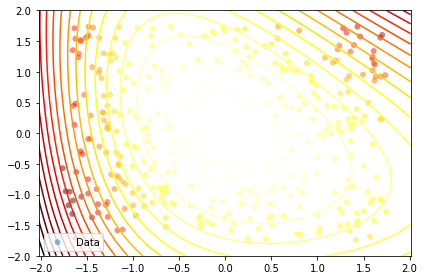

In [17]:
fig = gp.plot()
fig

# Slicing

GP's allow to gauge the measure of uncertainty in prediction by looking at variance for different inputs. 
Here we take a linear kernel, as it was a bad fit, and see how uncertainty changes depending on value of second parameter. Linear kernel is quite close to the model (low uncertainty) near the true value for second parameter (500).

In [18]:
slice_emu = emulator.GPEmulator(log_likelihood, 
                                input_parameters, 
                                likelihoods,
                                normalize_input = True)
slice_emu.set_parameters(kernel = GPy.kern.Linear(input_dim))
slice_emu.fit(messages = False, normalizer = True)

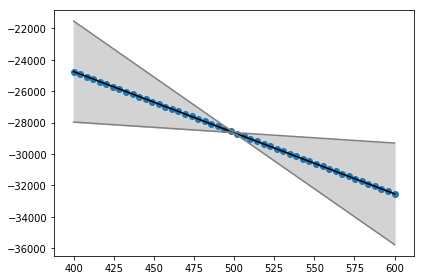

In [19]:
test_k_range = np.linspace(400, 600, 50)
r_slice_val = 0.015
r_arr = np.zeros(len(test_k_range)) + r_slice_val
slice_data = np.dstack((r_arr, test_k_range)).squeeze()
slice_data

#prediction returns mean and variance
mean, var = slice_emu.predict(slice_data)
# convert to 1D
mean, var = mean.flatten(), var.flatten()

#for 95% confidence add/subtract 2 std
conf = 2 * np.sqrt(var)


fig, ax = emuplt.confidence_interval(test_k_range, mean, conf)
plt.show(fig)

## Using the emulator

In [20]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(emu, log_prior)

We use the resulting posterior as we normally would in pints

In [21]:
xs = [
    np.array(real_parameters) * 0.9,
    np.array(real_parameters) * 1.05,
    np.array(real_parameters) * 1.15,
]
xs

[array([1.35e-02, 4.50e+02]),
 array([1.575e-02, 5.250e+02]),
 array([1.725e-02, 5.750e+02])]

In [22]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.0952    0.0476    0.0476     0:00.0
40    123    0.0488    0.0244    0.0732     0:00.1
60    183    0.0328    0.0328    0.0492     0:00.1
80    243    0.0247    0.0247    0.037      0:00.1
100   303    0.0297    0.0198    0.0396     0:00.1
120   363    0.0248    0.0165    0.0331     0:00.1
140   423    0.0284    0.0213    0.0284     0:00.2
160   483    0.0248    0.0248    0.0311     0:00.2
180   543    0.0221    0.0221    0.0276     0:00.2


 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.


200   603    0.0249    0.0199    0.0249     0:00.2
220   663    0.0317    0.0271    0.0407     0:00.3
240   723    0.0622    0.0498    0.0539     0:00.3
260   783    0.092     0.0805    0.0805     0:00.3
280   843    0.107     0.11      0.0961     0:00.4
300   903    0.116     0.133     0.116      0:00.4
320   963    0.121     0.143     0.14       0:00.5
340   1023   0.141     0.161     0.155      0:00.5
360   1083   0.158     0.169     0.166205   0:00.6
380   1143   0.165     0.186     0.175853   0:00.6
400   1203   0.157     0.19202   0.19202    0:00.6
420   1263   0.15      0.202     0.211      0:00.7
440   1323   0.145     0.2       0.218      0:00.7
460   1383   0.139     0.202     0.226      0:00.8
480   1443   0.141     0.2       0.22       0:00.8
500   1503   0.154     0.192     0.212      0:00.9
520   1563   0.165     0.19      0.205      0:00.9
540   1623   0.179     0.192     0.198      0:00.9
560   1683   0.194     0.194     0.193      0:01.0
580   1743   0.211704  0.201   

3500  10503  0.307912  0.308     0.323      0:07.2
3520  10563  0.308     0.308     0.323      0:07.3
3540  10623  0.308     0.308     0.323      0:07.3
3560  10683  0.307     0.308     0.321      0:07.4
3580  10743  0.306339  0.308573  0.32       0:07.4
3600  10803  0.307     0.309     0.321      0:07.4
3620  10863  0.307     0.309     0.32       0:07.5
3640  10923  0.307     0.308981  0.319      0:07.5
3660  10983  0.306     0.309     0.318      0:07.6
3680  11043  0.306     0.309     0.317      0:07.6
3700  11103  0.306     0.309     0.317      0:07.7
3720  11163  0.306     0.308788  0.317      0:07.7
3740  11223  0.306     0.308741  0.317      0:07.7
3760  11283  0.307     0.308     0.318      0:07.8
3780  11343  0.306     0.308     0.317      0:07.8
3800  11403  0.306     0.307     0.317      0:07.9
3820  11463  0.307     0.306726  0.317      0:07.9
3840  11523  0.308     0.307     0.318      0:08.0
3860  11583  0.307     0.308     0.32       0:08.0
3880  11643  0.307395  0.307   

6760  20283  0.305     0.307     0.31       0:14.2
6780  20343  0.305     0.307     0.309      0:14.2
6800  20403  0.305     0.307     0.309      0:14.2
6820  20463  0.305     0.307     0.309      0:14.3
6840  20523  0.305     0.307     0.308873   0:14.3
6860  20583  0.305     0.306     0.308      0:14.4
6880  20643  0.305     0.306     0.308      0:14.4
6900  20703  0.305     0.306     0.309      0:14.5
6920  20763  0.305     0.306     0.309      0:14.5
6940  20823  0.305     0.306     0.308457   0:14.5
6960  20883  0.305     0.306     0.308      0:14.6
6980  20943  0.304     0.305     0.308122   0:14.6
7000  21003  0.304     0.305     0.308      0:14.7
7020  21063  0.304     0.305     0.308      0:14.7
7040  21123  0.303508  0.305     0.307      0:14.7
7060  21183  0.303     0.305     0.307      0:14.8
7080  21243  0.304     0.306     0.30716    0:14.8
7100  21303  0.304     0.306     0.307      0:14.9
7120  21363  0.304     0.305     0.307      0:14.9
7140  21423  0.303     0.306   

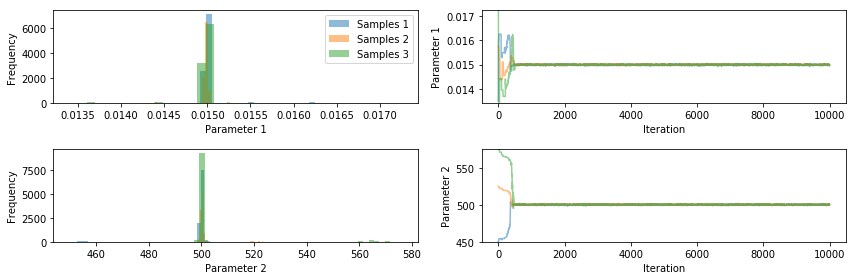

In [23]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Compare this with the parameter estimation for the original likelihood

In [24]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [25]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0.25      0         0          0:00.0
20    63     0.0476    0.0476    0.0952     0:00.0
40    123    0.0244    0.0488    0.0732     0:00.0
60    183    0.0164    0.0492    0.0492     0:00.0
80    243    0.0123    0.037     0.037      0:00.0
100   303    0.0297    0.0297    0.0297     0:00.1
120   363    0.0331    0.0248    0.0331     0:00.1
140   423    0.0284    0.0213    0.0284     0:00.1
160   483    0.0435    0.0248    0.0248     0:00.1
180   543    0.0442    0.0221    0.0221     0:00.1
200   603    0.0448    0.0199    0.0199     0:00.1
220   663    0.0543    0.0181    0.0362     0:00.1
240   723    0.0788    0.029     0.0622     0:00.1
260   783    0.092     0.0651    0.107      0:00.1
28

3300  9903   0.315     0.308     0.301      0:02.1
3320  9963   0.315     0.308     0.301      0:02.1
3340  10023  0.315     0.308     0.301      0:02.1
3360  10083  0.314     0.307     0.302      0:02.1
3380  10143  0.313     0.308     0.301      0:02.2
3400  10203  0.312     0.308     0.301      0:02.2
3420  10263  0.312     0.308     0.301      0:02.2
3440  10323  0.313     0.30805   0.301      0:02.2
3460  10383  0.314     0.307     0.301      0:02.2
3480  10443  0.313703  0.306     0.3        0:02.2
3500  10503  0.313339  0.307     0.3        0:02.2
3520  10563  0.314     0.305879  0.3        0:02.2
3540  10623  0.314     0.306     0.299      0:02.2
3560  10683  0.313     0.305     0.299      0:02.3
3580  10743  0.314     0.305222  0.299      0:02.3
3600  10803  0.313     0.306     0.299639   0:02.3
3620  10863  0.313     0.306     0.3        0:02.3
3640  10923  0.312     0.306     0.301      0:02.3
3660  10983  0.312     0.305381  0.3        0:02.3
3680  11043  0.313     0.306   

6620  19863  0.306     0.302     0.308      0:04.2
6640  19923  0.306     0.302     0.307785   0:04.2
6660  19983  0.306     0.301     0.308      0:04.2
6680  20043  0.306     0.301     0.308      0:04.2
6700  20103  0.305     0.301     0.307      0:04.3
6720  20163  0.305     0.301     0.308      0:04.3
6740  20223  0.305     0.302     0.307      0:04.3
6760  20283  0.305     0.302     0.307351   0:04.3
6780  20343  0.305     0.301     0.307      0:04.3
6800  20403  0.305     0.302     0.307      0:04.3
6820  20463  0.305     0.302     0.307      0:04.3
6840  20523  0.305     0.301     0.307      0:04.3
6860  20583  0.305     0.301268  0.307      0:04.4
6880  20643  0.305     0.301     0.307      0:04.4
6900  20703  0.304     0.301     0.307      0:04.4
6920  20763  0.304     0.301     0.308      0:04.4
6940  20823  0.304     0.302     0.308      0:04.4
6960  20883  0.304     0.302     0.308      0:04.4
6980  20943  0.304     0.302     0.308      0:04.4
7000  21003  0.304     0.301   

9840  29523  0.304     0.301     0.3        0:06.3
9860  29583  0.304     0.301     0.3        0:06.3
9880  29643  0.304     0.301     0.299666   0:06.3
9900  29703  0.304     0.3       0.3        0:06.3
9920  29763  0.304     0.301     0.3        0:06.3
9940  29823  0.304     0.300674  0.299668   0:06.3
9960  29883  0.304     0.301     0.299      0:06.3
9980  29943  0.304     0.301     0.3        0:06.4
10000 30000  0.3044    0.3014    0.2996     0:06.4
Halting: Maximum number of iterations (10000) reached.


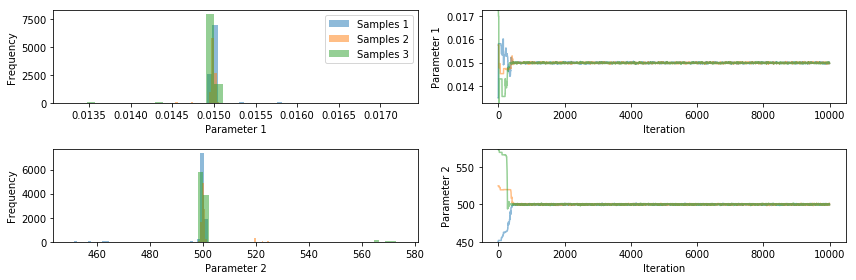

In [26]:
pints.plot.trace(chains)
plt.show()

Plotting likelihood differences along one chain

In [27]:
chain = chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()

diffs = np.abs(model_prediction - emu_prediction)

 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.


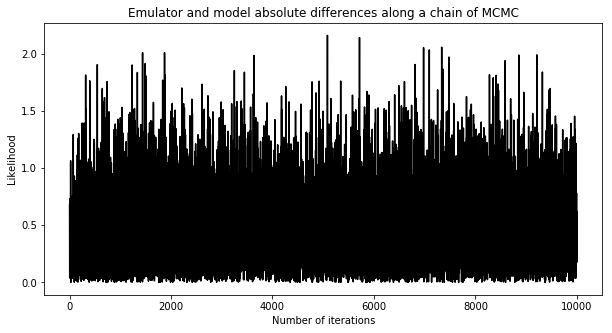

In [28]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

This shows us that a emulator is a good fit, as during the execution of MCMC emulator is likely to return values that are close (+/- 4) to the real values

Let's see how the parameter values for MCMC are distributed

In [29]:
r_vals = chain[:, 0]
k_vals = chain[:, 1]
print(r_vals.shape, k_vals.shape)

(10000,) (10000,)


 /anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


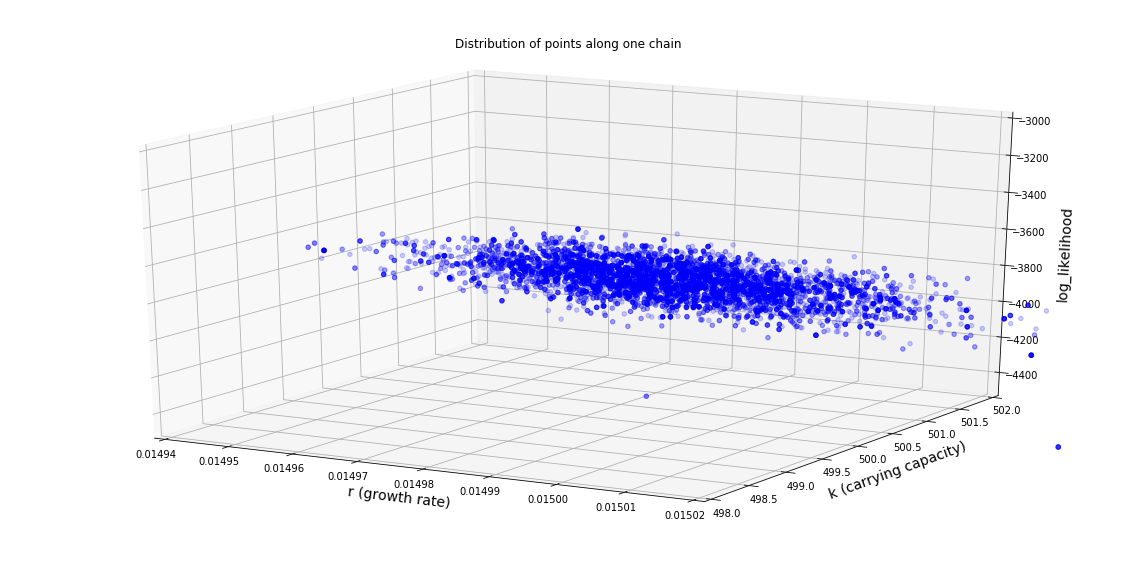

In [30]:
plt.figure(figsize=(20, 10))
plt.title("Distribution of points along one chain")
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
ax.scatter(r_vals, k_vals, model_prediction, c = "b", alpha = 0.2)

fontsize = 14
labelpad = 10

ax.set_ylim(498, 502)
ax.set_xlim(0.01494, 0.01502)
ax.set_zlim(-4500, -3000)

ax.set_xlabel('r (growth rate)', fontsize = fontsize, labelpad = labelpad)
ax.set_ylabel('k (carrying capacity)', fontsize = fontsize, labelpad = labelpad)
ax.set_zlabel('log_likelihood', fontsize = fontsize, labelpad = labelpad)
ax.set_title("Distribution of points along one chain")

ax.view_init(20, 300)

In [31]:
test_split = 50
r_min, r_max = r_vals.min(), r_vals.max()
k_min, k_max = k_vals.min(), k_vals.max()
r_grid, k_grid, test_data = emutils.generate_grid([r_min, k_min], [r_max, k_max], test_splits)

In [32]:
model_prediction = emutils.predict_grid(log_likelihood, test_data)
emu_prediction = emutils.predict_grid(emu, test_data)
diffs = model_prediction - emu_prediction

 /anaconda3/lib/python3.6/site-packages/GPy/core/gp.py:588: RuntimeWarning:covariance is not positive-semidefinite.


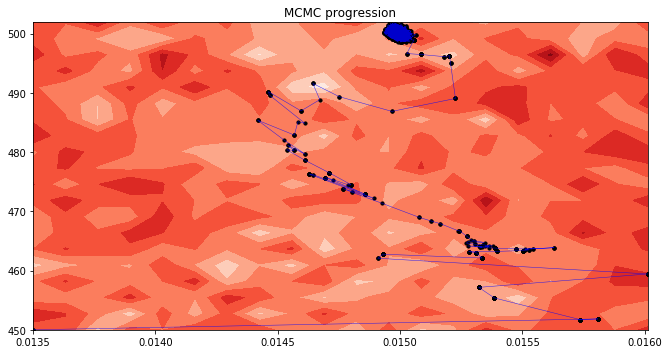

In [33]:
fig, ax = emuplt.contour(r_grid, k_grid, diffs, cmap = "Reds", fill = True)
fig.set_size_inches((10, 5))
ax.plot(r_vals, k_vals, color = 'blue', alpha = 0.8, linewidth = 0.5)
ax.scatter(r_vals, k_vals, color = 'black', s = 10)

ax.set_title("MCMC progression")
# scatter plot causes some points to leave the axis so we need to manually specify bounds
ax.set_xlim(r_grid.min(), r_grid.max())
ax.set_ylim(k_grid.min(), k_grid.max())
plt.show()

It's clear that MCMC climbs quite quickly to the values near the true parameter values [.015, 500], and most of the points after initial 100 are concentrated there. Hence, when training the model it's better to include training data that has high likelihood, as it's very likely that the emulator will be approaching that area. (Active sampling) <br>
Alternatively, makes sure that the bounds for each parameter are small, as otherwise GP will have a hard time correctly estimating the required small region.